In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from functools import partial

import jax
import jax.numpy as jnp

import tornadox
import matplotlib.pyplot as plt
from tqdm.notebook import trange

import pof
from pof.main import (
    make_continuous_models,
    discretize_transitions,
    get_initial_trajectory,
    linearize_observation_model,
    taylor_mode_init,
    # get_sigmasq_estimate,
)
import pof.ieks
import pof.transitions
from pof.ieks import filtsmooth
from pof.ivp import lotkavolterra, logistic
from pof.solve import solve_diffrax

In [4]:
ivp = lotkavolterra()
# ivp = logistic()
# ivp = tornadox.ivp.vanderpol_julia(stiffness_constant=1e2, tmax=8)

In [5]:
ts_true, ys_true, sol_true = solve_diffrax(ivp, atol=1e-16, rtol=1e-16)

In [6]:
order = 4
dt = 2 ** -6
ts = jnp.arange(0, ivp.tmax + dt, dt)
dt, (ivp.t_span[1]-ivp.t_span[0])/dt

(0.015625, 448.0)

In [7]:
x0 = taylor_mode_init(ivp, order)

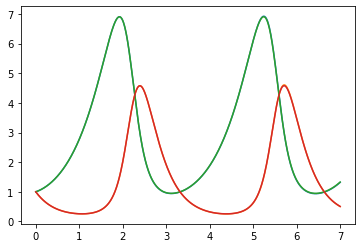

In [8]:
_, _, sol_init = solve_diffrax(ivp, dt=0.25)
ts_init, ys_init = ts, jax.vmap(sol_init.evaluate)(ts)

traj = get_initial_trajectory(ys_init, ivp.f, order)

plt.plot(ts_init, ys_init)
plt.plot(ts_true, ys_true)

In [9]:
iwp, om = make_continuous_models(ivp, order)
E0 = pof.transitions.projection_matrix(iwp, 0)
dtm = discretize_transitions(iwp, ts)
lom = jax.jit(linearize_observation_model, static_argnums=0)

In [10]:
#fs = jax.jit(filtsmooth)
fs = filtsmooth

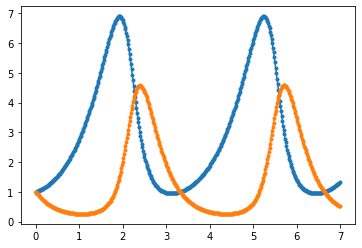

In [11]:
dom = lom(om, traj[1:])
out, nll, obj = fs(x0, dtm, dom)
ys = jnp.dot(E0, out.mean.T).T
fig, ax = plt.subplots(1, 1)
ax.plot(ts, ys, marker=".")
#ax.set_ylim(-3, 3)

In [12]:
dom = lom(om, traj[1:])
out, nll, obj = fs(x0, dtm, dom)

nlls = [nll]
objs = [obj]
#print(f"{nll}")
pbar = trange(100)
nll_old, obj_old = 0, 0
for i in pbar:
    dom = lom(om, out.mean[1:])
    out, nll, obj = fs(x0, dtm, dom)
    #pbar.write(f"nll={nll}, obj={obj}")
    nlls.append(nll)
    objs.append(obj)
    if jnp.isclose(nll_old, nll) and jnp.isclose(obj_old, obj):
        break
    nll_old, obj_old = nll, obj

  0%|          | 0/100 [00:00<?, ?it/s]

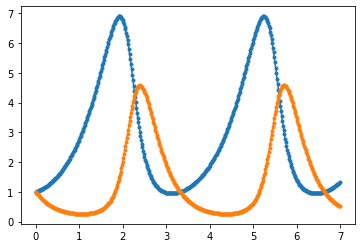

In [13]:
ys = jnp.dot(E0, out.mean.T).T
fig, ax = plt.subplots(1, 1)
ax.plot(ts, ys, marker=".")
#ax.set_ylim(-3, 3)

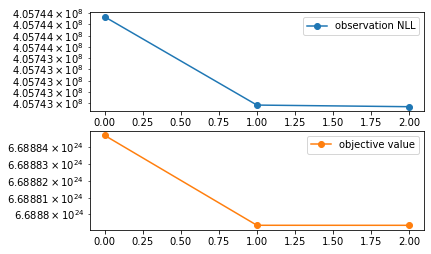

In [14]:
fig, axes = plt.subplots(2, 1)
axes[0].plot(nlls[:], marker="o", label="observation NLL", color="C0")
axes[0].set_yscale("log")
axes[0].legend()
axes[1].plot(objs[:], marker="o", label="objective value", color="C1")
axes[1].set_yscale("log")
axes[1].legend()

In [15]:
jnp.isclose(nll_old, nll) and jnp.isclose(obj_old, obj)

DeviceArray(True, dtype=bool)

Text(0.5, 1.0, 'Error')

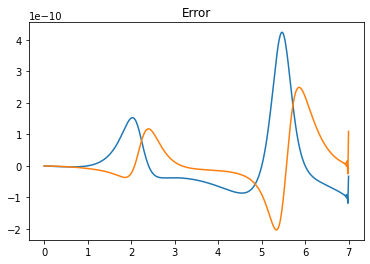

In [16]:
plt.plot(ts, jax.vmap(sol_true.evaluate)(ts) - ys)
#plt.plot(ts, jax.vmap(sol_true.evaluate)(ts) - ys_init)
plt.title("Error")

Text(0, 0.5, "x' - f(x)")

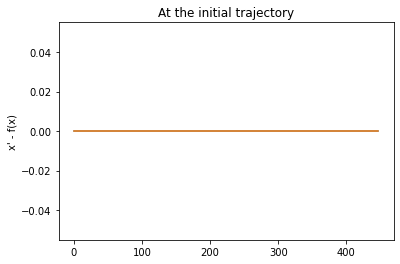

In [29]:
# How does the information operator look
dom = lom(om, traj[1:])
plt.plot(jax.vmap(lambda x, H, b: H @ x + b)(traj[1:], dom.H, dom.b))
plt.title("At the initial trajectory")
plt.ylabel("x' - f(x)")

Text(0, 0.5, "x' - f(x)")

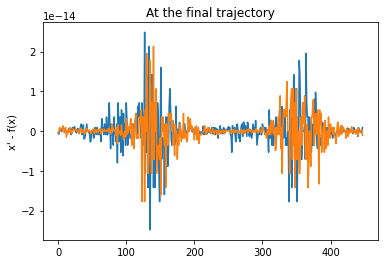

In [30]:
dom = lom(om, out.mean[1:])
plt.plot(jax.vmap(lambda x, H, b: H @ x + b)(out.mean[1:], dom.H, dom.b))
plt.title("At the final trajectory")
plt.ylabel("x' - f(x)")

# Timings

In [ ]:
def linearize_and_filtsmooth(out, om, x0, dtm):
    return fs(x0, dtm, lom(om, out.mean[1:]))

laf = partial(linearize_and_filtsmooth, om=om, x0=x0, dtm=dtm)

laf(out);

In [ ]:
%%timeit 
o, *_ = laf(out)
o.mean.block_until_ready();

In [ ]:
fn = jax.jit(laf)

In [ ]:
%%timeit 
o, *_ = fn(out)
o.mean.block_until_ready();

In [ ]:
%%timeit
__ts, __ys, _ = solve_diffrax(ivp, dt=dt)
__ys.block_until_ready()

In [ ]:
dfn = jax.jit(lambda: solve_diffrax(ivp, dt=dt))

In [ ]:
%%timeit
__ts, __ys, _ = dfn()
__ys.block_until_ready()

In [ ]:
from scipy.integrate import solve_ivp

In [ ]:
%%timeit
sol = solve_ivp(ivp.f, ivp.t_span, ivp.y0, method='RK45', max_step=2 ** -10)

In [ ]:
%%timeit
sol = solve_ivp(ivp.f, ivp.t_span, ivp.y0, method='LSODA', max_step=2 ** -10)